# Cell type annotation from marker genes

https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Path
data = "/mnt/d12b/SINGLECELL/dataset/PBMC3K/data"

## Loading packages

In [4]:
import scanpy as sc
import anndata as ad
import decoupler as dc
import numpy as np

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Single-cell processing

### Loading dataset

In [5]:
# Read PBMC3K as an Anndata
adata = ad.read_h5ad(f'{data}'"/pbmc3k_raw.h5ad")

### QC, Projection and Clustering

In [6]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

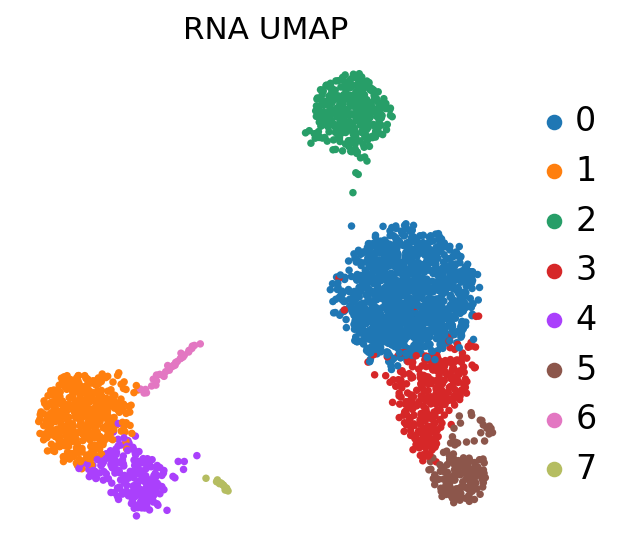

In [7]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Regress and scale the data 
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) ## Regress out (mostly) unwanted sources of variation.
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

## Marker genes

 Marker genes were discovered and annotated in previous studies and there are some resources that collect and curate them.

In [8]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.000000,0.018170,True,0.000000,0.000000,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000


In [9]:
markers["human"].value_counts()

human
True     7877
False     584
Name: count, dtype: int64

### Filtering

In [10]:
# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
14,PRSS3,True,Acinar cells,Endoderm,True,0.833333,0.028931,True,0.028571,0.000000,9606,Pancreas,0.006
15,CELA3A,True,Acinar cells,Endoderm,True,0.833333,0.000000,True,0.128571,0.000000,9606,Pancreas,0.001
17,PRSS1,True,Acinar cells,Endoderm,True,1.000000,0.005975,True,0.028571,0.000000,9606,Pancreas,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,TRBC2,True,T cells,Mesoderm,True,0.940711,0.083362,True,0.000000,0.000000,9606,Immune system,0.066
8266,TRAC,True,T cytotoxic cells,Mesoderm,True,1.000000,0.131348,True,0.000000,0.000000,9606,Immune system,0.042
8267,TRAC,True,T cells,Mesoderm,True,0.972332,0.059544,True,0.000000,0.000000,9606,Immune system,0.042
8297,LCK,True,T cells,Mesoderm,True,0.648221,0.033004,True,0.705607,0.030902,9606,Immune system,0.048


## Enrichment with Over Representation Analysis (ORA)

For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S), and for the latter a user-defined significance filtering can be used.

In [11]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

1 features of mat are empty, they will be removed.
Running ora on mat with 2638 samples and 13713 targets for 36 sources.


100%|██████████| 2638/2638 [00:05<00:00, 508.49it/s]


The obtained scores (-log10(p-value))`(ora_estimate)` and p-values (`ora_pvals`) are stored in the `.obsm key`:

In [12]:
adata.obsm['ora_estimate']

source,Acinar cells,Adipocytes,Alpha cells,B cells,B cells naive,Dendritic cells,Ductal cells,Endothelial cells,Enterocytes,Ependymal cells,...,Pancreatic stellate cells,Pericytes,Plasma cells,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells
AAACATACAACCAC-1,-0.000000,0.530653,0.885021,4.065376,2.641014,5.720316,-0.000000,-0.000000,-0.000000,-0.0,...,-0.0,0.885021,2.538999,0.437907,1.871866,-0.000000,-0.000000,-0.0,-0.0,11.728494
AAACATTGAGCTAC-1,-0.000000,-0.000000,0.885021,5.618952,13.894150,13.010816,2.171878,0.827013,0.795482,-0.0,...,-0.0,0.885021,2.538999,0.437907,2.858756,-0.000000,-0.000000,-0.0,-0.0,2.981581
AAACATTGATCAGC-1,-0.000000,0.530653,0.885021,1.542530,6.107693,5.720316,-0.000000,0.298770,-0.000000,-0.0,...,-0.0,0.885021,0.569257,-0.000000,5.213387,-0.000000,0.613213,-0.0,-0.0,9.970169
AAACCGTGCTTCCG-1,0.613213,1.356127,0.885021,2.703919,2.641014,20.564684,0.885021,0.827013,-0.000000,-0.0,...,-0.0,-0.000000,1.443226,0.437907,8.019237,0.613213,-0.000000,-0.0,-0.0,1.957728
AAACCGTGTATGCG-1,-0.000000,-0.000000,0.885021,1.542530,0.349060,9.831072,-0.000000,0.298770,0.795482,-0.0,...,-0.0,-0.000000,0.569257,0.437907,2.858756,-0.000000,0.613213,-0.0,-0.0,1.957728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.613213,1.356127,0.885021,4.065376,2.641014,22.778754,2.171878,1.527899,-0.000000,-0.0,...,-0.0,0.885021,2.538999,1.146495,3.976687,-0.000000,-0.000000,-0.0,-0.0,2.981581
TTTCTACTGAGGCA-1,-0.000000,-0.000000,0.885021,5.618952,2.641014,8.373145,0.885021,0.298770,-0.000000,-0.0,...,-0.0,0.885021,8.735716,1.146495,3.976687,-0.000000,-0.000000,-0.0,-0.0,1.957728
TTTCTACTTCCTCG-1,-0.000000,-0.000000,0.885021,9.375833,15.767762,14.738433,-0.000000,-0.000000,0.795482,-0.0,...,-0.0,-0.000000,3.822062,1.146495,2.858756,-0.000000,0.613213,-0.0,-0.0,2.981581
TTTGCATGAGAGGC-1,-0.000000,-0.000000,-0.000000,7.375963,7.468516,9.831072,-0.000000,-0.000000,0.795482,-0.0,...,-0.0,-0.000000,1.443226,0.437907,2.858756,-0.000000,1.542530,-0.0,-0.0,1.957728


### Visualization

In [13]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 2638 × 36
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

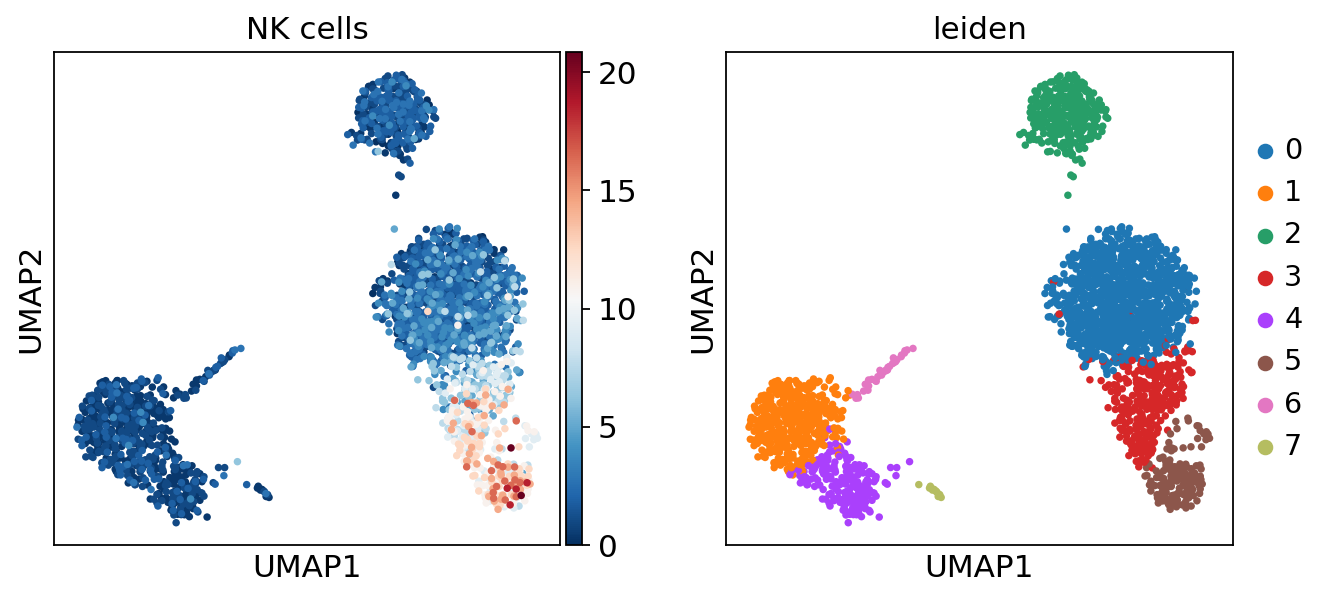

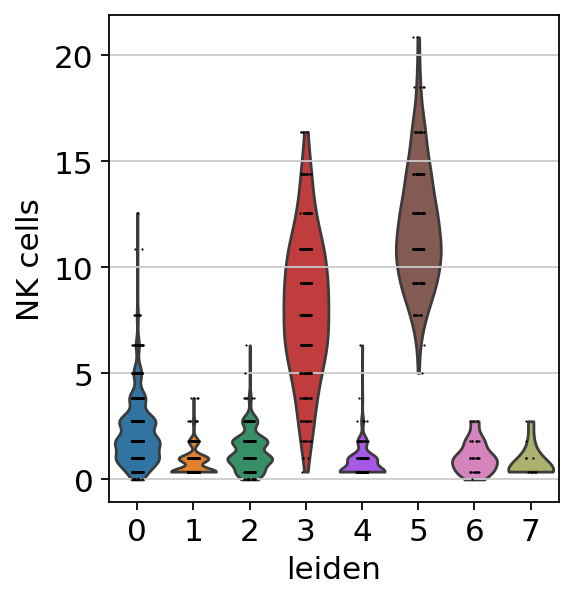

In [14]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

## Annotation

In [15]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T cells,43.372538,5.579798,6.171307e-300,2.221671e-298
1,0,rest,Erythroid-like and erythroid precursor cells,8.042804,0.144541,1.400976e-15,2.654481e-15
2,0,rest,Pericytes,7.022572,0.127029,2.862101e-12,4.906458e-12
3,0,rest,Neurons,6.068221,0.097898,1.513801e-09,2.477129e-09
4,0,rest,Oligodendrocytes,5.136233,0.062480,3.056686e-07,4.585029e-07
...,...,...,...,...,...,...,...
283,7,rest,Dendritic cells,-2.597187,-4.715218,1.639940e-02,4.541372e-02
284,7,rest,Pericytes,-2.656430,-0.430002,1.390428e-02,4.171283e-02
285,7,rest,B cells naive,-2.846163,-2.872803,1.328863e-02,4.171283e-02
286,7,rest,Ductal cells,-3.244715,-0.672322,5.497033e-03,1.978932e-02


In [16]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['T cells', 'Erythroid-like and erythroid precursor cells', 'Pericytes'],
 '1': ['Neutrophils', 'Acinar cells', 'Dendritic cells'],
 '2': ['B cells naive', 'B cells', 'Plasma cells'],
 '3': ['NK cells', 'Gamma delta T cells', 'T cells'],
 '4': ['Macrophages', 'Dendritic cells', 'Monocytes'],
 '5': ['Gamma delta T cells', 'NK cells', 'Hepatic stellate cells'],
 '6': ['Dendritic cells', 'Acinar cells', 'Ductal cells'],
 '7': ['Pancreatic stellate cells', 'Platelets', 'Endothelial cells']}

We can visualize the obtained top predicted cell types:

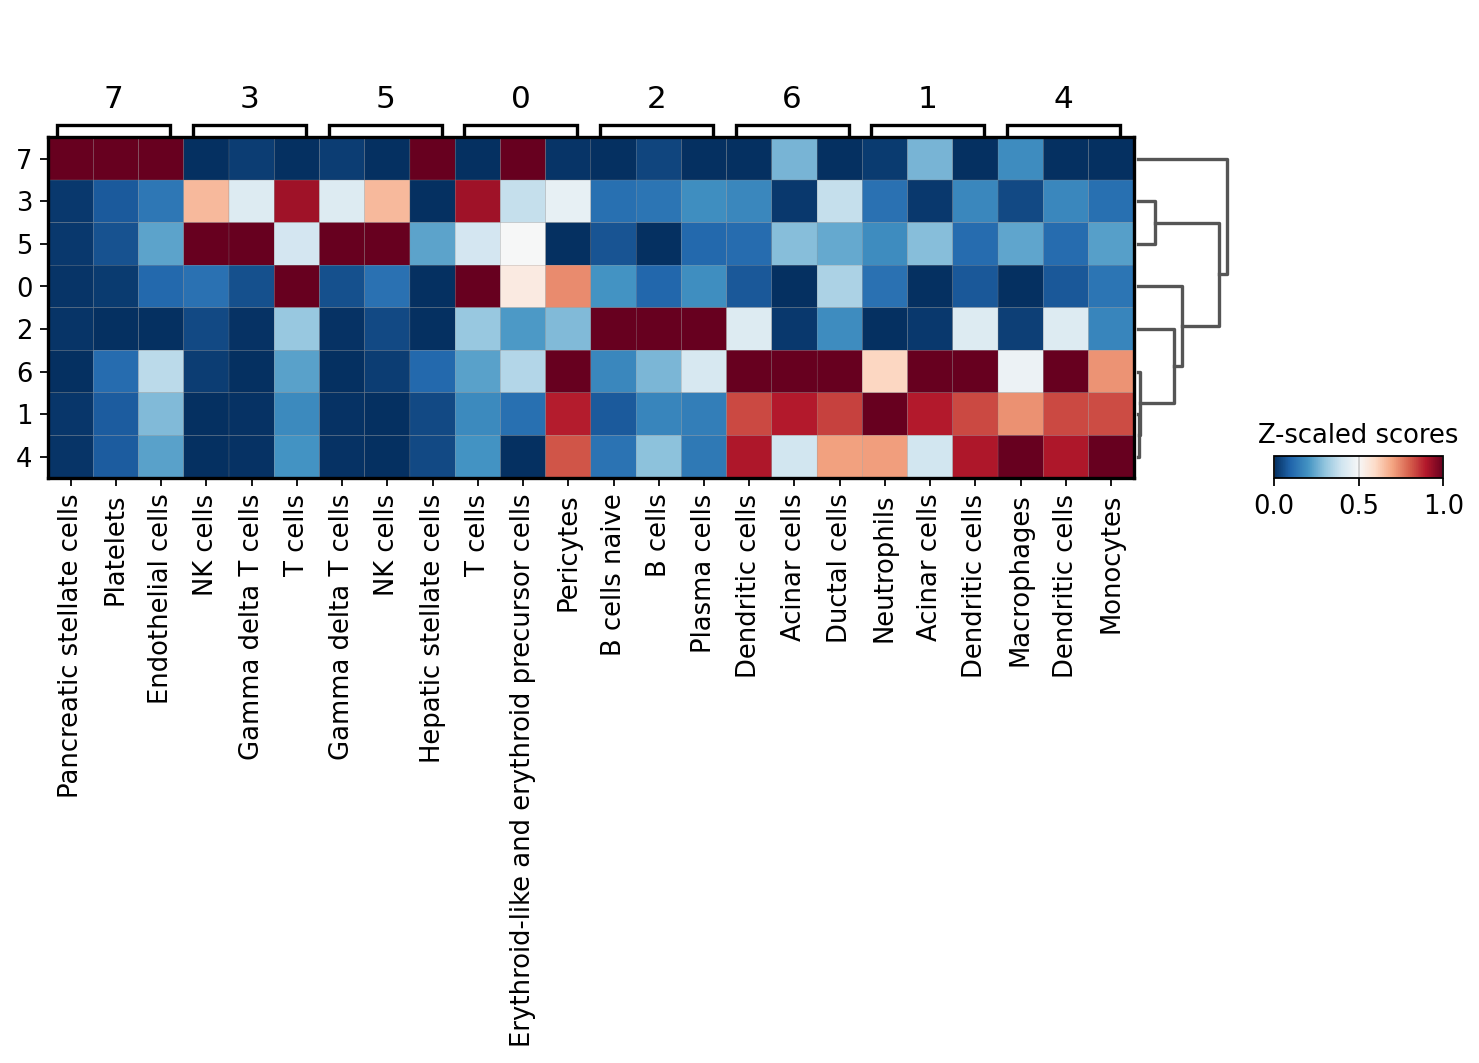

In [17]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

We can check individual cell types by plotting their distributions:

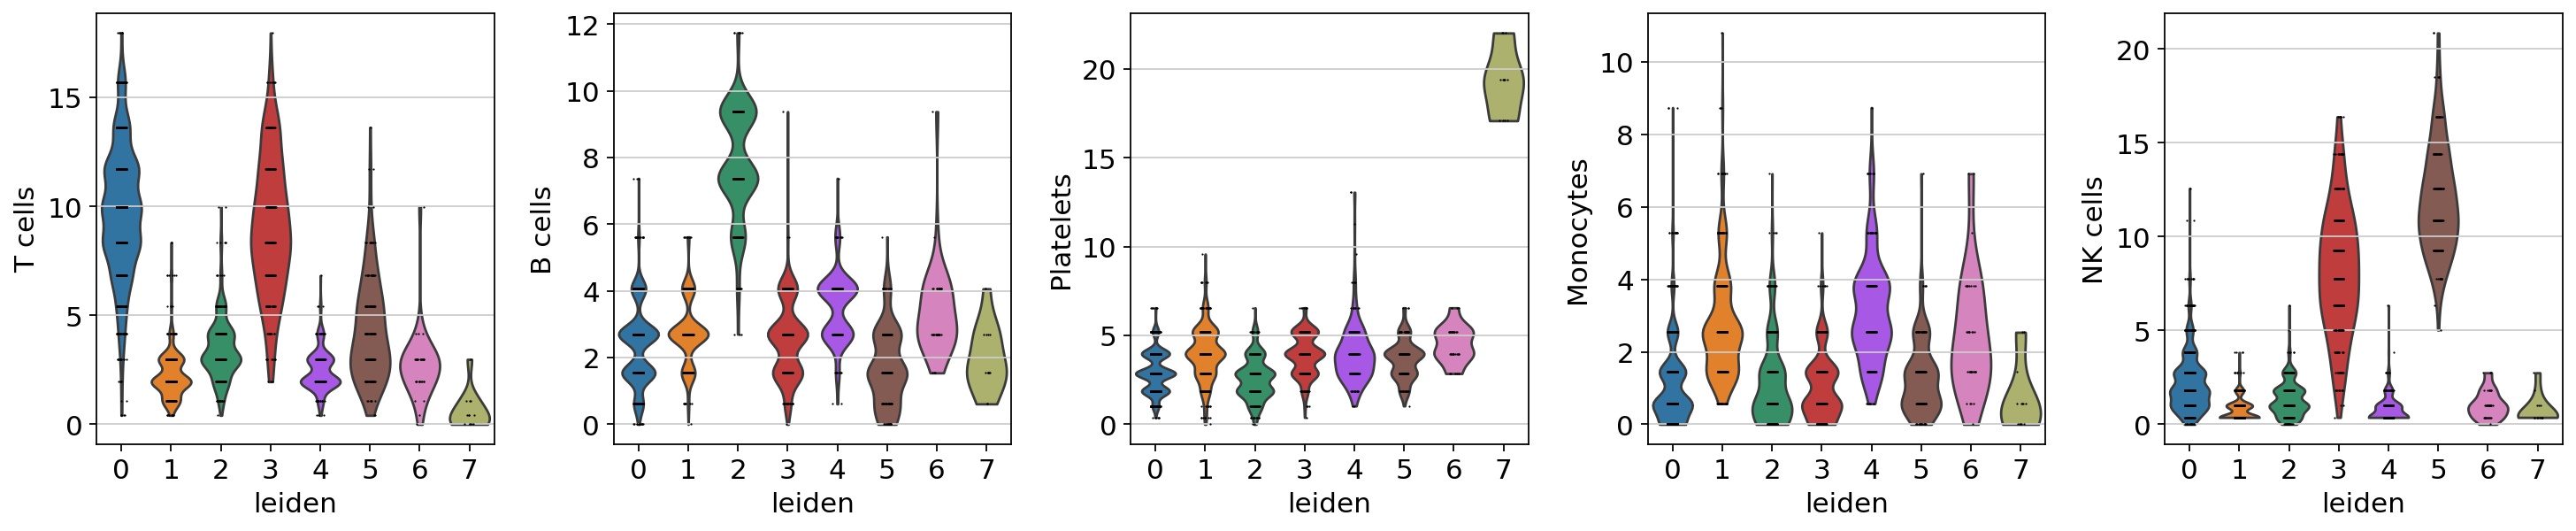

In [18]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')

In [19]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'T cells',
 '1': 'Neutrophils',
 '2': 'B cells naive',
 '3': 'NK cells',
 '4': 'Macrophages',
 '5': 'Gamma delta T cells',
 '6': 'Dendritic cells',
 '7': 'Pancreatic stellate cells'}

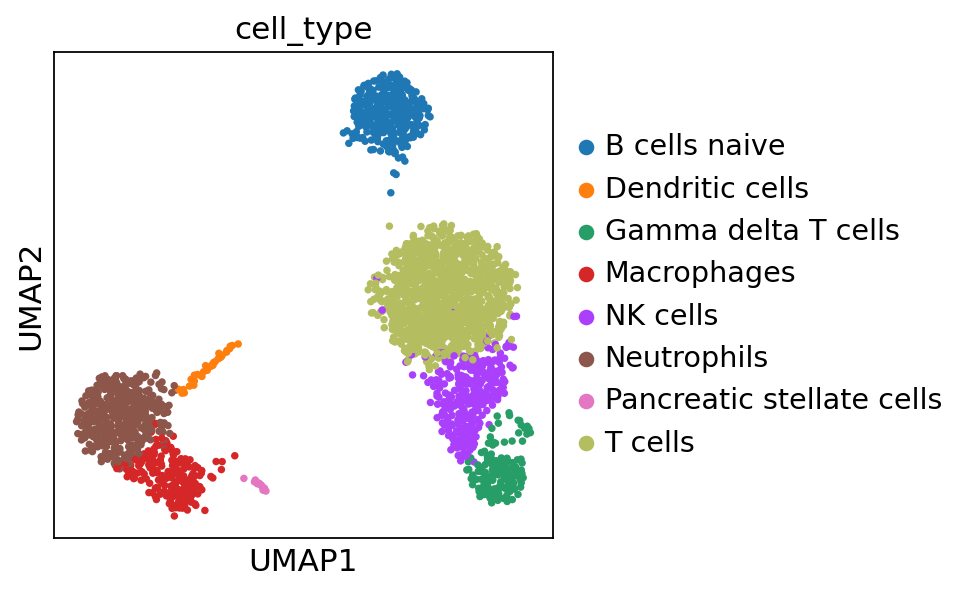

In [20]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

In [21]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'dendrogram_leiden', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities'

In [24]:
import hdf5plugin
adata.write_h5ad(
    f'{data}/pbmc3k_processed.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)